Helper script for looking at the response

In [1]:
# now open in napari
import napari
import tifffile
import os
import numpy as np

In [2]:
data_dir = 'data_proc'
experimenter = 'jm'
mouse = 'jm048'
session = '2025-05-12_c'
channel = 2
plane = 0
frame_period = 0.033602476 # exact frame period from metadata (for '30Hz' acquisition)
fov_shape = (512, 512) # shape of the FOV in pixels

# visualisation parameters
uint12_max = 4095 * 2 # for conversion to uint8
make_anim = False

define a loader for stimulation points (in space) and for the stimulation protocol (in time)

In [3]:
session_path = os.path.join(data_dir, experimenter, mouse, session)
s2p_path = os.path.join(session_path, 'suite2p', f'plane{plane}')
tiff_dir = os.path.join(s2p_path, f'reg_tif_chan{channel}')
all_tiff_paths = [tiff_path for tiff_path in os.listdir(tiff_dir) if tiff_path.endswith('.tif')]
all_tiff_paths.sort()
print(s2p_path)
print(tiff_dir)
print(all_tiff_paths)


data_proc/jm/jm048/2025-05-12_c/suite2p/plane0
data_proc/jm/jm048/2025-05-12_c/suite2p/plane0/reg_tif_chan2
['file00000_chan1.tif', 'file002000_chan1.tif', 'file004000_chan1.tif', 'file006000_chan1.tif']


In [4]:
# import the necessary package for parsing xml
import xml.etree.ElementTree as ET


In [5]:
# i guess all can be loaded from the mark points? e.g. make a list of stimuli based on the parameters of the mark points file...22
def parse_mark_points(session_path):
    """
    Loads and parses the MarkPoints.xml file in the session path.
    Returns a dictionary with the parameters of the mark points and the stimulation protocol as set in the PrairieView software.
    
    Parameters
    ----------
    session_path : str
        The path to the session directory containing the MarkPoints.xml file.

    Returns
    -------
    mp_dict : dict
        A dictionary with the parameters of the mark points and the stimulation protocol as set in the PrairieView software.

    """

    mark_points_file = [f for f in os.listdir(session_path) if f.endswith('MarkPoints.xml')]
    if len(mark_points_file) == 0:
        raise FileNotFoundError("No MarkPoints.xml file found in session path")
    elif len(mark_points_file) > 1:
        raise FileExistsError("Multiple MarkPoints.xml files found in session path")
    else:
        mark_points_file = mark_points_file[0]
    
    print(f"Found MarkPoints.xml file: {mark_points_file}")

    xml_data = ET.parse(os.path.join(session_path, mark_points_file))
    root = xml_data.getroot()

    mp_dict = {}

    all_point_dict = []

    for elem in root.iter():
        if elem.tag != 'Point':
            for key, value in elem.attrib.items():
                if key not in mp_dict:
                    mp_dict[key] = value
                else:
                    print(f"Key {key} already exists in dictionary with value {mp_dict[key]}. Overwriting with value {value}.")
        
        # if an element is a 'Point' treat it differently (by appending to list), since it is not unique (e. g. there can be multiple stimulation points)
        else:
            point_dict = {}
            for key, value in elem.attrib.items():
                if key not in mp_dict:
                    point_dict[key] = value
                else:
                    print(f"Key {key} already exists in dictionary with value {point_dict[key]}. Overwriting with value {value}.")

            all_point_dict.append(point_dict)


    mp_dict['AllPoint'] = all_point_dict

    return mp_dict


In [6]:
mp_dict = parse_mark_points(session_path)
for key, value in mp_dict.items():
    print(f"Key: {key}, Value: {value}")

Found MarkPoints.xml file: TSeries-10032023-1822-006_Cycle00001_MarkPoints.xml
Key: Iterations, Value: 1
Key: IterationDelay, Value: 0.00
Key: CalcFunctMap, Value: False
Key: Repetitions, Value: 40
Key: UncagingLaser, Value: Uncaging
Key: UncagingLaserPower, Value: 1000
Key: TriggerFrequency, Value: None
Key: TriggerSelection, Value: None
Key: TriggerCount, Value: 1
Key: AsyncSyncFrequency, Value: None
Key: VoltageOutputCategoryName, Value: None
Key: VoltageRecCategoryName, Value: None
Key: parameterSet, Value: CurrentSettings
Key: InitialDelay, Value: 60000
Key: InterPointDelay, Value: 950
Key: Duration, Value: 50
Key: SpiralRevolutions, Value: 7
Key: AllPointsAtOnce, Value: False
Key: Use3D, Value: False
Key: Points, Value: Group 1
Key: Indices, Value: 1-4
Key: AllPoint, Value: [{'Index': '1', 'X': '0.549824150058617', 'Y': '0.701836654943337', 'IsSpiral': 'True', 'SpiralWidth': '0.0199325637636341', 'SpiralHeight': '0.0199325637636341', 'SpiralSizeInMicrons': '15.0000000000001'}, {'

In [7]:
def mp_dict_to_stim_list(mp_dict, frame_period = 0.033602476):
    """
    Convert the mark points dictionary to a list of stimulation times (in seconds), corresponding frame index and point index for each stimulation.

    Parameters:
    ----------
    mp_dict : dict
        The mark points dictionary containing the parameters of the mark points and the stimulation protocol as set in the PrairieView software.
    frame_period : float
        Exact frame period from metadata used to convert from time to frame index. Default is 0.033602476 (for '30Hz' acquisition).
    
    Returns:
    -------
    stim_times : list
        A list of stimulation times, corresponding frame index and point index for each stimulation.
    stim_frames : list
        A list of frame indices for each stimulation.
    stim_points : list
        Index of stimulated point corresponding to each stimulation.

    """
    initial_delay = float(mp_dict['InitialDelay'])
    inter_point_delay = float(mp_dict['InterPointDelay'])
    duration = float(mp_dict['Duration'])
    repetitions = int(mp_dict['Repetitions'])
    n_points = len(mp_dict['AllPoint'])

    n_stim = n_points * repetitions

    stim_times = np.zeros((n_stim))
    stim_frames = np.zeros((n_stim))
    stim_points = np.zeros((n_stim))

    for i in range(n_stim):
        # points go from 0 to n_points - 1 and then reset
        stim_times[i] = (initial_delay + i * (inter_point_delay + duration)) / 1000
        stim_frames[i] = int(stim_times[i] / frame_period)
        stim_points[i] = i % n_points


    return stim_times, stim_frames, stim_points



In [8]:
stim_times, stim_frames, stim_points = mp_dict_to_stim_list(mp_dict, frame_period = frame_period)

In [9]:
# plot the protocol
import matplotlib.pyplot as plt

In [10]:
# now check in suite2p if it looks like it makes sense
s2p_idx = 49 # point_idx 1: 401, 49, point_idx 2: 203, 88  
point_idx = 1 # response to which stimulus
f = np.load(os.path.join(s2p_path, 'F.npy'), allow_pickle=True)



(np.float64(1600.0),
 np.float64(6517.0),
 np.float64(5.544154453277587),
 np.float64(252.49426145553588))

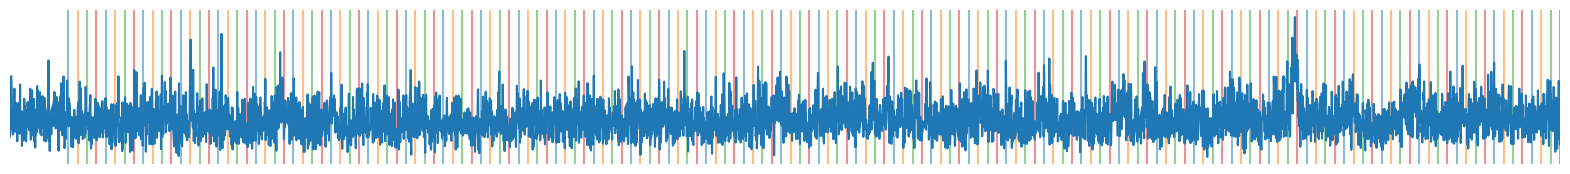

In [11]:
plt.figure(figsize=(20, 2))

for (i, frame) in enumerate(stim_frames):
    plt.axvline(frame, color=f'C{int(stim_points[i])}', alpha=0.5)

plt.plot(f[s2p_idx,:])
plt.xlim(1600, np.max(stim_frames))
plt.axis('off')

(2000.0, 3000.0)

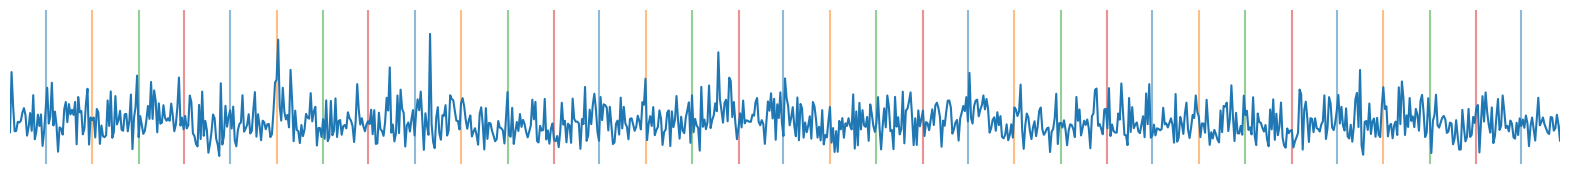

In [12]:
plt.figure(figsize=(20, 2))

for (i, frame) in enumerate(stim_frames):
    plt.axvline(frame, color=f'C{int(stim_points[i])}', alpha=0.5)

plt.plot(f[s2p_idx,:])
plt.xlim(1600, np.max(stim_frames))
plt.axis('off')
plt.xlim(2000, 3000)

In [13]:
peristim_wind = [10, 30] # +- in frames
repetitions = int(mp_dict['Repetitions'])

resp_mat = np.zeros((repetitions, peristim_wind[0] + peristim_wind[1] + 1))

count = 0
for (i, point) in enumerate(stim_points):
    frame = int(stim_frames[i])
    if point == point_idx:
        resp_mat[count, :] = f[s2p_idx, frame - peristim_wind[0]:frame + peristim_wind[1] + 1]
        count += 1




([<matplotlib.axis.XTick at 0x10eccbb10>,
 [Text(10.0, 0, '0'), Text(25.0, 0, '0.5'), Text(40.0, 0, '1')])

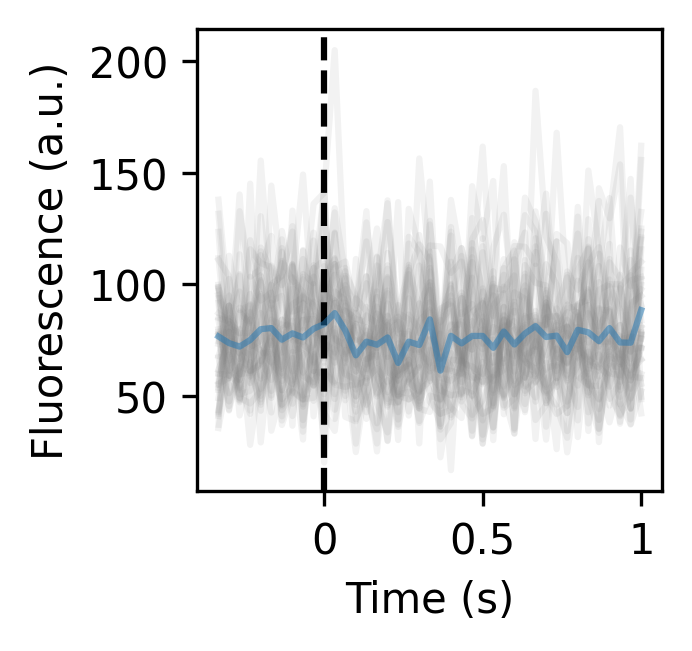

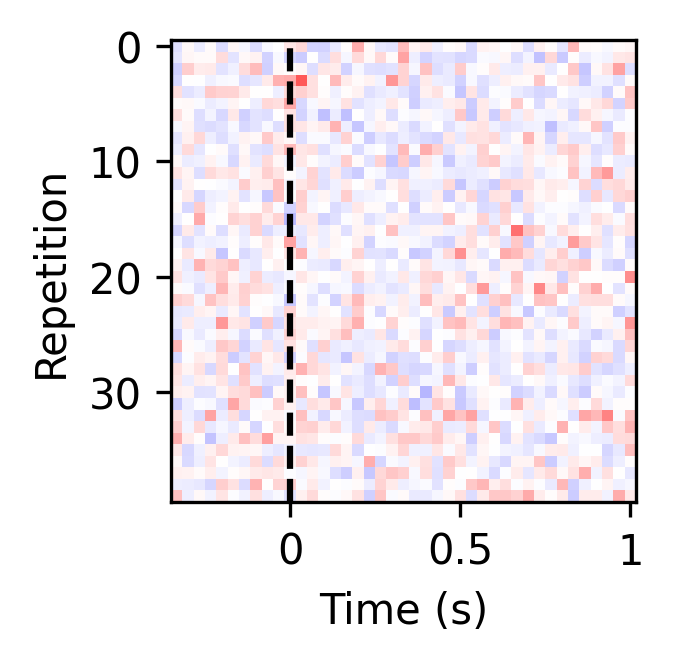

In [14]:
plt.figure(figsize=(2, 2), dpi=300)
plt.plot(resp_mat.T, color='grey', alpha=0.1)
plt.plot(np.mean(resp_mat, axis=0), color='C0', alpha=0.5, zorder=10)
plt.axvline(peristim_wind[0], color='k', linestyle='--')
plt.ylabel('Fluorescence (a.u.)') 
plt.xlabel('Time (s)')
plt.xticks([peristim_wind[0], (peristim_wind[1])/2 + peristim_wind[0], peristim_wind[1] + peristim_wind[0]], [0, 0.5, 1])     

plt.figure(figsize=(2, 2), dpi=300)
plt.imshow(resp_mat, aspect='auto', cmap='bwr', vmin=np.median(resp_mat) - 8 * np.std(resp_mat), vmax=np.median(resp_mat) + 8 * np.std(resp_mat))
plt.axvline(peristim_wind[0], color='k', linestyle='--')
plt.ylabel('Repetition')
plt.xlabel('Time (s)')
plt.xticks([peristim_wind[0], (peristim_wind[1])/2 + peristim_wind[0], peristim_wind[1] + peristim_wind[0]], [0, 0.5, 1])

In [15]:
all_tiff = []
for tiff_path in all_tiff_paths:
    print(f'Loading {tiff_path}')
    tiff = tifffile.imread(os.path.join(tiff_dir, tiff_path))
    tiff = tiff / uint12_max * 255
    tiff = tiff.astype(np.uint8)
    all_tiff.append(tiff)
    # print(f'Loaded {tiff.shape} image')

all_tiff = np.concatenate(all_tiff, axis=0)

Loading file00000_chan1.tif
Loading file002000_chan1.tif
Loading file004000_chan1.tif
Loading file006000_chan1.tif


In [16]:
# now compute the coordinates of the stimulations
point_coords = np.zeros((len(mp_dict['AllPoint']), 2))
for i, point in enumerate(mp_dict['AllPoint']):
    point_coords[i, 0] = float(point['Y']) * fov_shape[0]
    point_coords[i, 1] = float(point['X'])  * fov_shape[1]

print(point_coords)

[[359.34036733 281.50996483]
 [321.12543962 294.71512309]
 [338.53223916 344.13442751]
 [348.73622509 364.34232122]]


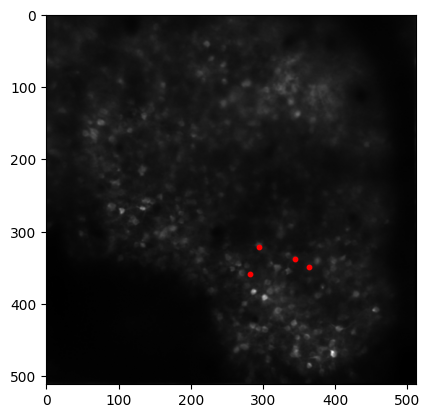

In [17]:
ops = np.load(os.path.join(s2p_path, 'ops.npy'), allow_pickle=True).item()
mn_image = ops['meanImg']

plt.imshow(mn_image, cmap='gray', vmax=500)
plt.scatter(point_coords[:, 1], point_coords[:, 0], c='r', s=10)

In [18]:
box_size = [250, 250]
centroid = np.mean(point_coords, axis=0)
centroid_xy_shift = [0, 0]

crop_mask = np.zeros(fov_shape, dtype=bool)
crop_mask[int(centroid[0] - box_size[0] / 2):int(centroid[0] + box_size[0] / 2), int(centroid[1] - box_size[1] / 2):int(centroid[1] + box_size[1] / 2)] = True
crop_mn_image = mn_image[crop_mask].reshape((box_size[1], box_size[0]))

crop_point_coords = point_coords - np.array([centroid[0] - box_size[0] / 2, centroid[1] - box_size[1] / 2]) + centroid_xy_shift


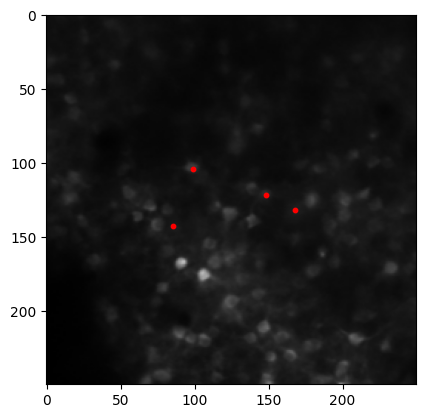

In [19]:
plt.imshow(crop_mn_image, cmap='gray', vmax=500)
plt.scatter(crop_point_coords[:, 1], crop_point_coords[:, 0], c='r', s=10)

In [20]:
crop_tiff = all_tiff[:, crop_mask].reshape((all_tiff.shape[0], box_size[1], box_size[0]))
# remove all_tiff from memory
del all_tiff
# garbage collection
import gc
gc.collect()


50

In [23]:
from napari_animation import Animation

/opt/anaconda3/envs/napari_test/lib/python3.13/site-packages/napari_animation/easing.py:269: FutureWarning: functools.partial will be a method descriptor in future Python versions; wrap it in enum.member() if you want to preserve the old behavior
  LINEAR = partial(linear_interpolation)
/opt/anaconda3/envs/napari_test/lib/python3.13/site-packages/napari_animation/easing.py:270: FutureWarning: functools.partial will be a method descriptor in future Python versions; wrap it in enum.member() if you want to preserve the old behavior
  QUADRATIC = partial(quadratic_ease_in_out)
/opt/anaconda3/envs/napari_test/lib/python3.13/site-packages/napari_animation/easing.py:271: FutureWarning: functools.partial will be a method descriptor in future Python versions; wrap it in enum.member() if you want to preserve the old behavior
  CUBIC = partial(cubic_ease_in_out)
/opt/anaconda3/envs/napari_test/lib/python3.13/site-packages/napari_animation/easing.py:272: FutureWarning: functools.partial will be a 

In [24]:
# now show it in gui
labels = [1, 2, 3, 4]
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
size = 30
properties = {'label': labels}

with napari.gui_qt():
    viewer = napari.Viewer()
    viewer.add_image(crop_tiff, name=f'{experimenter}_{mouse}_{session}_plane{plane}_chan{channel}', colormap='gray')
    # add points
    viewer.add_points(crop_point_coords, name='stimulations', size=0, properties=properties, text={'string': labels, 'color': colors, 'size': size})
    # set frame rate to 30 fps

    if make_anim:
        anim = Animation(viewer)

        for i in np.arange(4150, 4150 + 5 * 120):
            viewer.dims.set_point(0, i)
            anim.capture_keyframe()
    

AttributeError: No napari attribute gui_qt

In [30]:
if make_anim:
    anim.animate('stim.mp4', fps=300, quality=5)


In [31]:
# now make a video of the average stimulation (e.g. take the times from each stim0 and average them)
n_frames_cycle = int(stim_frames[stim_points == 0][1] - stim_frames[stim_points == 0][0])

crop_tiff_rep_avg = np.zeros((n_frames_cycle, crop_tiff.shape[1], crop_tiff.shape[2]))

for i in range(int(mp_dict['Repetitions'])-2):
    t_onset = int(stim_frames[stim_points == 0][i])
    t_offset = int(stim_frames[stim_points == 0][i + 1])

    if t_offset - t_onset != n_frames_cycle:
        t_offset = t_onset + n_frames_cycle
    print(i)
    print(f'Onset: {t_onset}, Offset: {t_offset}')
    crop_tiff_rep_avg += crop_tiff[t_onset:t_offset, :, :]

    
crop_tiff_rep_avg = crop_tiff_rep_avg / int(mp_dict['Repetitions'])


0
Onset: 1785, Offset: 1904
1
Onset: 1904, Offset: 2023
2
Onset: 2023, Offset: 2142
3
Onset: 2142, Offset: 2261
4
Onset: 2261, Offset: 2380
5
Onset: 2380, Offset: 2499
6
Onset: 2499, Offset: 2618
7
Onset: 2618, Offset: 2737
8
Onset: 2737, Offset: 2856
9
Onset: 2856, Offset: 2975
10
Onset: 2975, Offset: 3094
11
Onset: 3095, Offset: 3214
12
Onset: 3214, Offset: 3333
13
Onset: 3333, Offset: 3452
14
Onset: 3452, Offset: 3571
15
Onset: 3571, Offset: 3690
16
Onset: 3690, Offset: 3809
17
Onset: 3809, Offset: 3928
18
Onset: 3928, Offset: 4047
19
Onset: 4047, Offset: 4166
20
Onset: 4166, Offset: 4285
21
Onset: 4285, Offset: 4404
22
Onset: 4404, Offset: 4523
23
Onset: 4523, Offset: 4642
24
Onset: 4642, Offset: 4761
25
Onset: 4761, Offset: 4880
26
Onset: 4880, Offset: 4999
27
Onset: 4999, Offset: 5118
28
Onset: 5118, Offset: 5237
29
Onset: 5237, Offset: 5356
30
Onset: 5356, Offset: 5475
31
Onset: 5475, Offset: 5594
32
Onset: 5594, Offset: 5713
33
Onset: 5713, Offset: 5832
34
Onset: 5832, Offset: 

In [32]:
crop_tiff_rep_avg.shape

(119, 250, 250)

In [33]:

with napari.gui_qt():
    viewer = napari.Viewer()
    viewer.add_image(crop_tiff_rep_avg, name=f'{experimenter}_{mouse}_{session}_plane{plane}_chan{channel}', colormap='gray')
    viewer.add_points(crop_point_coords, name='stimulations', size=0, properties=properties, text={'string': labels, 'color': colors, 'size': size})


    if make_anim:
        anim = Animation(viewer)

        # set all frames as keyframes
        for i in range(crop_tiff_rep_avg.shape[0]):
            # go to frame i (dim 0 of crop_tiff_rep_avg)
            viewer.dims.set_point(0, i)
            anim.capture_keyframe()
        # set the fps to 30

if make_anim:
    anim.animate('stim_avg.mp4', fps=300, quality=5)


AttributeError: No napari attribute gui_qt

In [34]:
# get the average activations for each stimulus from the average
resp_duration = 10 # in frames
n_points = len(mp_dict['AllPoint'])
inter_stim_interval = 30 # in frames
# stim0_onset = 0
# stim1_onset = 30
# stim2_onset = 60
# stim3_onset = 90

# make the median projection be the baseline
crop_tiff_rep_avg_median = np.median(crop_tiff_rep_avg, axis=0)

all_mn_stim_resp = np.zeros((n_points, crop_tiff_rep_avg.shape[1], crop_tiff_rep_avg.shape[2]))

for i in range(all_mn_stim_resp.shape[0]):
    onset = i * inter_stim_interval
    offset = onset + resp_duration
    all_mn_stim_resp[i,:,:] = np.mean(crop_tiff_rep_avg[onset:offset, :, :], axis=0)



In [35]:
all_mn_stim_resp.shape

(4, 250, 250)

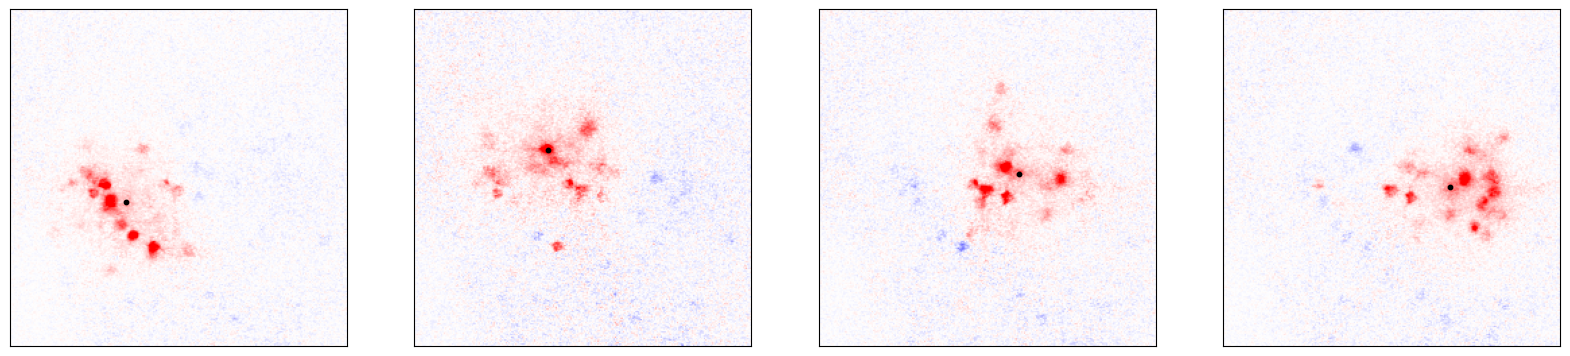

In [36]:
std_vis = 10

fig, axs = plt.subplots(1, n_points, figsize=(20, 5))

for i in range(all_mn_stim_resp.shape[0]):
    diff = crop_tiff_rep_avg_median- all_mn_stim_resp[i,:,:]
    # center on median of diff
    diff = diff - np.median(diff)

    axs[i].imshow(diff, cmap='bwr_r', vmin=np.std(diff) * -std_vis, vmax=np.std(diff) * std_vis)
    axs[i].scatter(crop_point_coords[i, 1], crop_point_coords[i, 0], c='black', s=10)
    # remove axis ticks and labels
    axs[i].set_xticks([])
    axs[i].set_yticks([])
